# Aridity 

### Description
Script calculates the Aridity Index (p/pet) for AGCD, ERA5, ERA5-land and downscaled CMIP6 models. Values for classification according to https://wad.jrc.ec.europa.eu/patternsaridity#:~:text=The%20Aridity%20Index%20(AI)%20is,climate%20at%20a%20given%20location.
Other reference: https://www.painblogr.org/2020-12-15-climate-change.html 

In [1]:
#< import modules
import os
import xarray as xr
import numpy as np
# import cmdline_provenance as cmdprov
# import git
import sys
import dask.distributed
import glob
from dask.distributed import Client
import tempfile
import dask
from dask.diagnostics import ProgressBar
import lib_david
import pickle

import warnings

# Ignore specific warning by category
warnings.filterwarnings('ignore') 

In [2]:
# Dask settings
dask.config.set({
    'array.chunk-size': "256 MiB",
    'array.slicing.split_large_chunks': True, # This can make AXIOM very slow
    'distributed.comm.timeouts.connect': '120s',
    'distributed.comm.timeouts.tcp': '120s',
    'distributed.comm.retry.count': 10,
    'distributed.scheduler.allowed-failures': 20,
    "distributed.scheduler.worker-saturation": 1.1, #< This should use the new behaviour which helps with memory pile up
})

enc = {"AI": {
        "zlib": True,
        "complevel": 1,
        "shuffle": True
        }
      }

client = Client(n_workers=20, threads_per_worker=1, local_directory = tempfile.mkdtemp(), memory_limit = "63000mb")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 20
Total threads: 20,Total memory: 1.15 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33219,Workers: 20
Dashboard: /proxy/8787/status,Total threads: 20
Started: Just now,Total memory: 1.15 TiB
Comm: tcp://127.0.0.1:42955,Total threads: 1
Dashboard: /proxy/33011/status,Memory: 58.67 GiB
Nanny: tcp://127.0.0.1:33805,


2024-05-29 14:22:54,156 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-pr-4dcf2f0be4f1a4b4bfd29464f2167236' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x14b3e5756950>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=_ElementwiseFunctionArray(LazilyIndexedArray(array=<xarray.backends.netCDF4_.NetCDF4ArrayWrapper object at 0x14b2cfab5940>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None)))), func=functools.partial(<function _apply_mask at 0x14b3e64dd000>, encoded

In [3]:
# client.close()

In [4]:
# #< FOR CMIP6 - set parameters 

# out_dir  = "/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/"

# # GWL2 from https://github.com/IPCC-WG1/Atlas/blob/main/warming-levels/CMIP6_Atlas_WarmingLevels.csv
# # and Mitch's email.

# climatology = {'recent':{'start':1991,'end':2020},
#                'current':{'start':2011,'end':2030},
#                # 'GWL2-ssp126':{
#                #     # 'CMCC-ESM2':{'start':-9,'end':+10}, # can't find it in table
#                #     'ACCESS-ESM1-5':{'start':2072-9,'end':2072+10},
#                #     'ACCESS-CM2':{'start':2042-9,'end':2042+10},
#                #     'EC-Earth3':{'start':2043-9,'end':2043+10},
#                #     # 'MPI-ESM1-2-HR':{'start':2050-9,'end':2050+10},
#                #     # 'NCAR-CESM2':{'start':-9,'end':+10}, can't find it in table
#                #     'NorESM2-MM':{'start':None,'end':None}},
#                'GWL2-ssp370':{
#                    'CMCC-ESM2':{'start':2041-9,'end':2041+10},
#                    'ACCESS-ESM1-5':{'start':2048-9,'end':2048+10},
#                    'ACCESS-CM2':{'start':2039-9,'end':2039+10},
#                    'EC-Earth3':{'start':2038-9,'end':2038+10},
#                    'MPI-ESM1-2-HR':{'start':2050-9,'end':2050+10},
#                    'NCAR-CESM2':{'start':2043-9,'end':2043+10},
#                    'NorESM2-MM':{'start':2062-9,'end':2062+10}}
#               }

# source_char = {
#     'ERA5':{'var_p':'pr','var_pet':'evspsblpot','var_lat':'lat','var_lon':'lon','files':[]},
#     'AGCD':{'var_p':'precip','var_pet':'e0','var_lat':'latitude','var_lon':'longitude','files':[]},
#     'CMIP6':{
#         'CMCC-ESM2':{'var_p':'pr','var_pet':'evspsblpot','var_lat':'lat','var_lon':'lon','files':[],'name':'CMCC-ESM2','variant-id':'r1i1p1f1','version':'v1-r1'}, 
#         'ACCESS-ESM1-5':{'var_p':'pr','var_pet':'evspsblpot','var_lat':'lat','var_lon':'lon','files':[],'name':'ACCESS-ESM1-5','variant-id':'r6i1p1f1','version':'v1-r1'},
#         'ACCESS-CM2':{'var_p':'pr','var_pet':'evspsblpot','var_lat':'lat','var_lon':'lon','files':[],'name':'ACCESS-CM2','variant-id':'r4i1p1f1','version':'v1-r1'},
#         'EC-Earth3':{'var_p':'pr','var_pet':'evspsblpot','var_lat':'lat','var_lon':'lon','files':[],'name':'EC-Earth3','variant-id':'r1i1p1f1','version':'v1-r1'},
#         'MPI-ESM1-2-HR':{'var_p':'pr','var_pet':'evspsblpot','var_lat':'lat','var_lon':'lon','files':[],'name':'MPI-ESM1-2-HR','variant-id':'r1i1p1f1','version':'v1-r1'}, # only historical},
#         'NCAR-CESM2':{'var_p':'pr','var_pet':'evspsblpot','var_lat':'lat','var_lon':'lon','files':[],'name':'CESM2','variant-id':'r11i1p1f1','version':'v1-r1'}, 
#         'NorESM2-MM':{'var_p':'pr','var_pet':'evspsblpot','var_lat':'lat','var_lon':'lon','files':[],'name':'NorESM2-MM','variant-id':'r1i1p1f1','version':'v1-r1'}
#         }
#     }

In [13]:
def calc_AI(pr_file,e0_file,syear,eyear):
    # Open data since it's a single file and resample annually
    da_e0 = xr.open_mfdataset(infile_e0).resample(time='YE').sum('time')
    da_pr  = xr.open_mfdataset(infile_pr).resample(time='YE').sum('time')

    # Select GWL periods
    e0 = da_e0.sel(time=slice(syear,eyear))['e0'].chunk({'time':-1,'lat':'auto','lon':'auto'})
    pr = da_pr.sel(time=slice(syear,eyear))['pr'].chunk({'time':-1,'lat':'auto','lon':'auto'})

    #Compute AI
    computed_AI = (pr/e0).mean('time').astype("float32").rename("AI")
    return computed_AI

In [14]:
#< FOR NHP1.0 (CMIP5)

# Specify the path to your .pkl file
file_path = '/g/data/mn51/users/dh4185/acs-drought/gwl_years.pkl'

# Open the file in binary read mode
with open(file_path, 'rb') as file:
    # Load the data from the file
    models_gwl = pickle.load(file)

print(models_gwl)
#< need to add 10 years to GWLs to calculate AI over 30 years?

path_templ_e0 = "/g/data/wj02/COMPLIANT_PUBLISHED/HMOUTPUT/output/AUS-5/BoM/"#{}/{}/{}/{}/latest/day/e0/"
path_templ_pr = "/g/data/wj02/COMPLIANT_PUBLISHED/HMINPUT/output/AUS-5/BoM/"#{}/{}/{}/{}/latest/day/pr/"

files_e0 = lib_david.get_file_paths(path_templ_e0,".nc",include=["rcp45","e0"]) + lib_david.get_file_paths(path_templ_e0,".nc",include=["rcp85","e0"])
files_pr = lib_david.get_file_paths(path_templ_pr,".nc",include=["rcp45","pr"],exclude=["BEFORE"]) + lib_david.get_file_paths(path_templ_pr,".nc",include=["rcp85","pr"],exclude=["BEFORE"])

bc_method = ["r240x120-QME","CSIRO-CCAM-r3355-r240x120-ISIMIP2b","_r240x120-ISIMIP2b","r240x120-MRNBC"]

# Create an empty DataArray with NaNs
initial_shape = (681, 841, 4, 4, 4, 2)
data = np.full(initial_shape, np.nan)
# Get lat and lon data from an example file -> need to figure out a better way to do this
da = xr.open_dataset("/g/data/wj02/COMPLIANT_PUBLISHED/HMOUTPUT/output/AUS-5/BoM/AWRALv6-1-CSIRO-BOM-ACCESS1-0/rcp45/r1i1p1/CSIRO-CCAM-r3355-r240x120-ISIMIP2b-AWAP/latest/day/e0/AWRALv6-1-CSIRO-BOM-ACCESS1-0_CSIRO-CCAM-r3355-r240x120-ISIMIP2b-AWAP_rcp45_r1i1p1_e0_AUS-5_day_v1_20060101-20991231.nc")
lat = da.lat
lon = da.lon


# # Create the initial empty DataArray
# extended_dataarray = xr.DataArray(
#     data,
#     dims=['lat', 'lon', 'GWL', 'BC', 'model', 'rcp'],
#     coords={'lat': lat, 'lon': lon, 'GWL': ['1.2','1.5','2','3','4'], 'BC': bc_method, 'model': ['ACCESS1-0','GFDL-ESM2M','MIROC5','CNRM-CM5'], 'rcp': ['rcp45','rcp85']},
#     name='AI'
# )

{'ACCESS1-0': {'rcp45': {'1.2': [2008, 2027], '1.5': [2022, 2041], '2': [2042, 2061]}, 'rcp85': {'1.2': [2010, 2029], '1.5': [2018, 2037], '2': [2031, 2050], '3': [2051, 2070], '4': [2071, 2090]}}, 'GFDL-ESM2M': {'rcp45': {'1.2': [2014, 2033], '1.5': [2037, 2056]}, 'rcp85': {'1.2': [2015, 2034], '1.5': [2027, 2046], '2': [2042, 2061], '3': [2073, 2092]}}, 'MIROC5': {'rcp45': {'1.2': [2019, 2038], '1.5': [2030, 2049], '2': [2063, 2082]}, 'rcp85': {'1.2': [2014, 2033], '1.5': [2024, 2043], '2': [2039, 2058], '3': [2063, 2082]}}, 'CNRM-CM5': {'rcp45': {'1.2': [2015, 2034], '1.5': [2028, 2047], '2': [2049, 2068]}, 'rcp85': {'1.2': [2011, 2030], '1.5': [2021, 2040], '2': [2036, 2055], '3': [2058, 2077], '4': [2078, 2097]}}}


In [ ]:
for model in models_gwl:
    print('========= '+model+' =========')
    
    for rcp in models_gwl[model]:
        files_e0 = lib_david.get_file_paths(path_templ_e0,".nc",include=[rcp,model,"e0"])
        files_pr = lib_david.get_file_paths(path_templ_pr,".nc",include=[rcp,model,"pr"],exclude=["BEFORE"])
        print(rcp)

        for bc in bc_method:
            infile_e0 = [filename for filename in files_e0 if bc in filename]
            infile_pr = [filename for filename in files_pr if bc in filename]
            print(bc)

            for gwl in models_gwl[model][rcp]:
                print(gwl)
                syear = str(models_gwl[model][rcp][gwl][0])
                eyear = str(models_gwl[model][rcp][gwl][1])

                file_name = "/scratch/mn51/dh4185/AI_NHP10_{}_{}_{}_{}.nc".format(model,bc,rcp,gwl)

                if os.path.exists(file_name)==False:
                    computed_AI = calc_AI(infile_pr,infile_e0,syear,eyear)
                    print("Computing {name}...".format(name=file_name))
                     #< Save output
                    saver = computed_AI.to_netcdf(file_name,compute=False)
                    future = client.persist(saver)
                    dask.distributed.progress(future)
                    future.compute()
                else:
                    print("{name} exists. Pass.".format(name=file_name))
                
                # # Store the computed AI data array in the dictionary
                # extended_dataarray.loc[dict(GWL=gwl, BC=bc, model=model, rcp=rcp)] = computed_AI
                  

#< Looking at files to check
# for item in path_e0:
#     print(item.split("/")[-1])

========= ACCESS1-0 =========
rcp45
r240x120-QME
1.2
/scratch/mn51/dh4185/AI_NHP10_ACCESS1-0_r240x120-QME_rcp45_1.2.nc exists. Pass.
1.5
/scratch/mn51/dh4185/AI_NHP10_ACCESS1-0_r240x120-QME_rcp45_1.5.nc exists. Pass.
2
/scratch/mn51/dh4185/AI_NHP10_ACCESS1-0_r240x120-QME_rcp45_2.nc exists. Pass.
CSIRO-CCAM-r3355-r240x120-ISIMIP2b
1.2
/scratch/mn51/dh4185/AI_NHP10_ACCESS1-0_CSIRO-CCAM-r3355-r240x120-ISIMIP2b_rcp45_1.2.nc exists. Pass.
1.5
/scratch/mn51/dh4185/AI_NHP10_ACCESS1-0_CSIRO-CCAM-r3355-r240x120-ISIMIP2b_rcp45_1.5.nc exists. Pass.
2
/scratch/mn51/dh4185/AI_NHP10_ACCESS1-0_CSIRO-CCAM-r3355-r240x120-ISIMIP2b_rcp45_2.nc exists. Pass.
_r240x120-ISIMIP2b
1.2
/scratch/mn51/dh4185/AI_NHP10_ACCESS1-0__r240x120-ISIMIP2b_rcp45_1.2.nc exists. Pass.
1.5
/scratch/mn51/dh4185/AI_NHP10_ACCESS1-0__r240x120-ISIMIP2b_rcp45_1.5.nc exists. Pass.
2
/scratch/mn51/dh4185/AI_NHP10_ACCESS1-0__r240x120-ISIMIP2b_rcp45_2.nc exists. Pass.
r240x120-MRNBC
1.2
/scratch/mn51/dh4185/AI_NHP10_ACCESS1-0_r240x120-M

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


2
Computing /scratch/mn51/dh4185/AI_NHP10_GFDL-ESM2M_r240x120-QME_rcp85_2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


3
Computing /scratch/mn51/dh4185/AI_NHP10_GFDL-ESM2M_r240x120-QME_rcp85_3.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


CSIRO-CCAM-r3355-r240x120-ISIMIP2b
1.2
Computing /scratch/mn51/dh4185/AI_NHP10_GFDL-ESM2M_CSIRO-CCAM-r3355-r240x120-ISIMIP2b_rcp85_1.2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


1.5
Computing /scratch/mn51/dh4185/AI_NHP10_GFDL-ESM2M_CSIRO-CCAM-r3355-r240x120-ISIMIP2b_rcp85_1.5.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


2
Computing /scratch/mn51/dh4185/AI_NHP10_GFDL-ESM2M_CSIRO-CCAM-r3355-r240x120-ISIMIP2b_rcp85_2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


3
Computing /scratch/mn51/dh4185/AI_NHP10_GFDL-ESM2M_CSIRO-CCAM-r3355-r240x120-ISIMIP2b_rcp85_3.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


_r240x120-ISIMIP2b
1.2
Computing /scratch/mn51/dh4185/AI_NHP10_GFDL-ESM2M__r240x120-ISIMIP2b_rcp85_1.2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


1.5
Computing /scratch/mn51/dh4185/AI_NHP10_GFDL-ESM2M__r240x120-ISIMIP2b_rcp85_1.5.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


2
Computing /scratch/mn51/dh4185/AI_NHP10_GFDL-ESM2M__r240x120-ISIMIP2b_rcp85_2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


3
Computing /scratch/mn51/dh4185/AI_NHP10_GFDL-ESM2M__r240x120-ISIMIP2b_rcp85_3.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


r240x120-MRNBC
1.2
Computing /scratch/mn51/dh4185/AI_NHP10_GFDL-ESM2M_r240x120-MRNBC_rcp85_1.2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


1.5
Computing /scratch/mn51/dh4185/AI_NHP10_GFDL-ESM2M_r240x120-MRNBC_rcp85_1.5.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


2
Computing /scratch/mn51/dh4185/AI_NHP10_GFDL-ESM2M_r240x120-MRNBC_rcp85_2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


3
Computing /scratch/mn51/dh4185/AI_NHP10_GFDL-ESM2M_r240x120-MRNBC_rcp85_3.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


========= MIROC5 =========
rcp45
r240x120-QME
1.2
Computing /scratch/mn51/dh4185/AI_NHP10_MIROC5_r240x120-QME_rcp45_1.2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


1.5
Computing /scratch/mn51/dh4185/AI_NHP10_MIROC5_r240x120-QME_rcp45_1.5.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


2
Computing /scratch/mn51/dh4185/AI_NHP10_MIROC5_r240x120-QME_rcp45_2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


CSIRO-CCAM-r3355-r240x120-ISIMIP2b
1.2
Computing /scratch/mn51/dh4185/AI_NHP10_MIROC5_CSIRO-CCAM-r3355-r240x120-ISIMIP2b_rcp45_1.2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


1.5
Computing /scratch/mn51/dh4185/AI_NHP10_MIROC5_CSIRO-CCAM-r3355-r240x120-ISIMIP2b_rcp45_1.5.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


2
Computing /scratch/mn51/dh4185/AI_NHP10_MIROC5_CSIRO-CCAM-r3355-r240x120-ISIMIP2b_rcp45_2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


_r240x120-ISIMIP2b
1.2
Computing /scratch/mn51/dh4185/AI_NHP10_MIROC5__r240x120-ISIMIP2b_rcp45_1.2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


1.5
Computing /scratch/mn51/dh4185/AI_NHP10_MIROC5__r240x120-ISIMIP2b_rcp45_1.5.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


2
Computing /scratch/mn51/dh4185/AI_NHP10_MIROC5__r240x120-ISIMIP2b_rcp45_2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


r240x120-MRNBC
1.2
Computing /scratch/mn51/dh4185/AI_NHP10_MIROC5_r240x120-MRNBC_rcp45_1.2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


1.5
Computing /scratch/mn51/dh4185/AI_NHP10_MIROC5_r240x120-MRNBC_rcp45_1.5.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


2
Computing /scratch/mn51/dh4185/AI_NHP10_MIROC5_r240x120-MRNBC_rcp45_2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


rcp85
r240x120-QME
1.2
Computing /scratch/mn51/dh4185/AI_NHP10_MIROC5_r240x120-QME_rcp85_1.2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


1.5
Computing /scratch/mn51/dh4185/AI_NHP10_MIROC5_r240x120-QME_rcp85_1.5.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


2
Computing /scratch/mn51/dh4185/AI_NHP10_MIROC5_r240x120-QME_rcp85_2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


3
Computing /scratch/mn51/dh4185/AI_NHP10_MIROC5_r240x120-QME_rcp85_3.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


CSIRO-CCAM-r3355-r240x120-ISIMIP2b
1.2
Computing /scratch/mn51/dh4185/AI_NHP10_MIROC5_CSIRO-CCAM-r3355-r240x120-ISIMIP2b_rcp85_1.2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


1.5
Computing /scratch/mn51/dh4185/AI_NHP10_MIROC5_CSIRO-CCAM-r3355-r240x120-ISIMIP2b_rcp85_1.5.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


2
Computing /scratch/mn51/dh4185/AI_NHP10_MIROC5_CSIRO-CCAM-r3355-r240x120-ISIMIP2b_rcp85_2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


3
Computing /scratch/mn51/dh4185/AI_NHP10_MIROC5_CSIRO-CCAM-r3355-r240x120-ISIMIP2b_rcp85_3.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


_r240x120-ISIMIP2b
1.2
Computing /scratch/mn51/dh4185/AI_NHP10_MIROC5__r240x120-ISIMIP2b_rcp85_1.2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


1.5
Computing /scratch/mn51/dh4185/AI_NHP10_MIROC5__r240x120-ISIMIP2b_rcp85_1.5.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


2
Computing /scratch/mn51/dh4185/AI_NHP10_MIROC5__r240x120-ISIMIP2b_rcp85_2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


3
Computing /scratch/mn51/dh4185/AI_NHP10_MIROC5__r240x120-ISIMIP2b_rcp85_3.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


r240x120-MRNBC
1.2
Computing /scratch/mn51/dh4185/AI_NHP10_MIROC5_r240x120-MRNBC_rcp85_1.2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


1.5
Computing /scratch/mn51/dh4185/AI_NHP10_MIROC5_r240x120-MRNBC_rcp85_1.5.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


2
Computing /scratch/mn51/dh4185/AI_NHP10_MIROC5_r240x120-MRNBC_rcp85_2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


3
Computing /scratch/mn51/dh4185/AI_NHP10_MIROC5_r240x120-MRNBC_rcp85_3.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


========= CNRM-CM5 =========
rcp45
r240x120-QME
1.2
Computing /scratch/mn51/dh4185/AI_NHP10_CNRM-CM5_r240x120-QME_rcp45_1.2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


1.5
Computing /scratch/mn51/dh4185/AI_NHP10_CNRM-CM5_r240x120-QME_rcp45_1.5.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


2
Computing /scratch/mn51/dh4185/AI_NHP10_CNRM-CM5_r240x120-QME_rcp45_2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


CSIRO-CCAM-r3355-r240x120-ISIMIP2b
1.2
Computing /scratch/mn51/dh4185/AI_NHP10_CNRM-CM5_CSIRO-CCAM-r3355-r240x120-ISIMIP2b_rcp45_1.2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


1.5
Computing /scratch/mn51/dh4185/AI_NHP10_CNRM-CM5_CSIRO-CCAM-r3355-r240x120-ISIMIP2b_rcp45_1.5.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


2
Computing /scratch/mn51/dh4185/AI_NHP10_CNRM-CM5_CSIRO-CCAM-r3355-r240x120-ISIMIP2b_rcp45_2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


_r240x120-ISIMIP2b
1.2
Computing /scratch/mn51/dh4185/AI_NHP10_CNRM-CM5__r240x120-ISIMIP2b_rcp45_1.2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


1.5
Computing /scratch/mn51/dh4185/AI_NHP10_CNRM-CM5__r240x120-ISIMIP2b_rcp45_1.5.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


2
Computing /scratch/mn51/dh4185/AI_NHP10_CNRM-CM5__r240x120-ISIMIP2b_rcp45_2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


r240x120-MRNBC
1.2
Computing /scratch/mn51/dh4185/AI_NHP10_CNRM-CM5_r240x120-MRNBC_rcp45_1.2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


1.5
Computing /scratch/mn51/dh4185/AI_NHP10_CNRM-CM5_r240x120-MRNBC_rcp45_1.5.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


2
Computing /scratch/mn51/dh4185/AI_NHP10_CNRM-CM5_r240x120-MRNBC_rcp45_2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


rcp85
r240x120-QME
1.2
Computing /scratch/mn51/dh4185/AI_NHP10_CNRM-CM5_r240x120-QME_rcp85_1.2.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


1.5
Computing /scratch/mn51/dh4185/AI_NHP10_CNRM-CM5_r240x120-QME_rcp85_1.5.nc...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


2
Computing /scratch/mn51/dh4185/AI_NHP10_CNRM-CM5_r240x120-QME_rcp85_2.nc...


In [15]:
root_dir = "/scratch/mn51/dh4185/"
files = lib_david.get_file_paths(root_dir,".nc",include=["AI"],exclude=["BEFORE"])
da_list = []
for file in files:
    model = file.split('_')[2]
    bc = file.split('_')[-3]
    rcp = file.split('_')[-2]
    gwl = file.split('_')[-1][:-3]

    print('Model: '+model, 'BC: '+bc, 'RCP: '+rcp, 'GWL: '+gwl)
    
    da = xr.open_dataset(file)['AI']
    da = da.expand_dims(dim={"model": [model],"bc": [bc],"rcp": [rcp],"gwl": [gwl]}, axis=[0,1,2,3])
    da_list.append(da)

da_all = xr.merge(da_list)
print(da_all)
# da.plot()#, "bc": bc, "rcp": rcp, "GWL": gwl})

Model: ACCESS1-0 BC: r240x120-MRNBC RCP: rcp85 GWL: 1.5
Model: ACCESS1-0 BC: r240x120-ISIMIP2b RCP: rcp45 GWL: 2
Model: GFDL-ESM2M BC: r240x120-ISIMIP2b RCP: rcp45 GWL: 1.5
Model: ACCESS1-0 BC: CSIRO-CCAM-r3355-r240x120-ISIMIP2b RCP: rcp85 GWL: 2
Model: ACCESS1-0 BC: r240x120-ISIMIP2b RCP: rcp45 GWL: 1.5
Model: ACCESS1-0 BC: r240x120-QME RCP: rcp45 GWL: 2
Model: ACCESS1-0 BC: r240x120-QME RCP: rcp85 GWL: 1.5
Model: ACCESS1-0 BC: CSIRO-CCAM-r3355-r240x120-ISIMIP2b RCP: rcp85 GWL: 1.2
Model: ACCESS1-0 BC: r240x120-QME RCP: rcp85 GWL: 1.2
Model: GFDL-ESM2M BC: r240x120-MRNBC RCP: rcp45 GWL: 1.5
Model: ACCESS1-0 BC: r240x120-ISIMIP2b RCP: rcp85 GWL: 1.2
Model: ACCESS1-0 BC: r240x120-QME RCP: rcp45 GWL: 1.2
Model: ACCESS1-0 BC: r240x120-MRNBC RCP: rcp85 GWL: 2
Model: GFDL-ESM2M BC: CSIRO-CCAM-r3355-r240x120-ISIMIP2b RCP: rcp45 GWL: 1.5
Model: ACCESS1-0 BC: r240x120-QME RCP: rcp85 GWL: 4
Model: ACCESS1-0 BC: r240x120-MRNBC RCP: rcp85 GWL: 1.2
Model: ACCESS1-0 BC: r240x120-ISIMIP2b RCP: rcp45

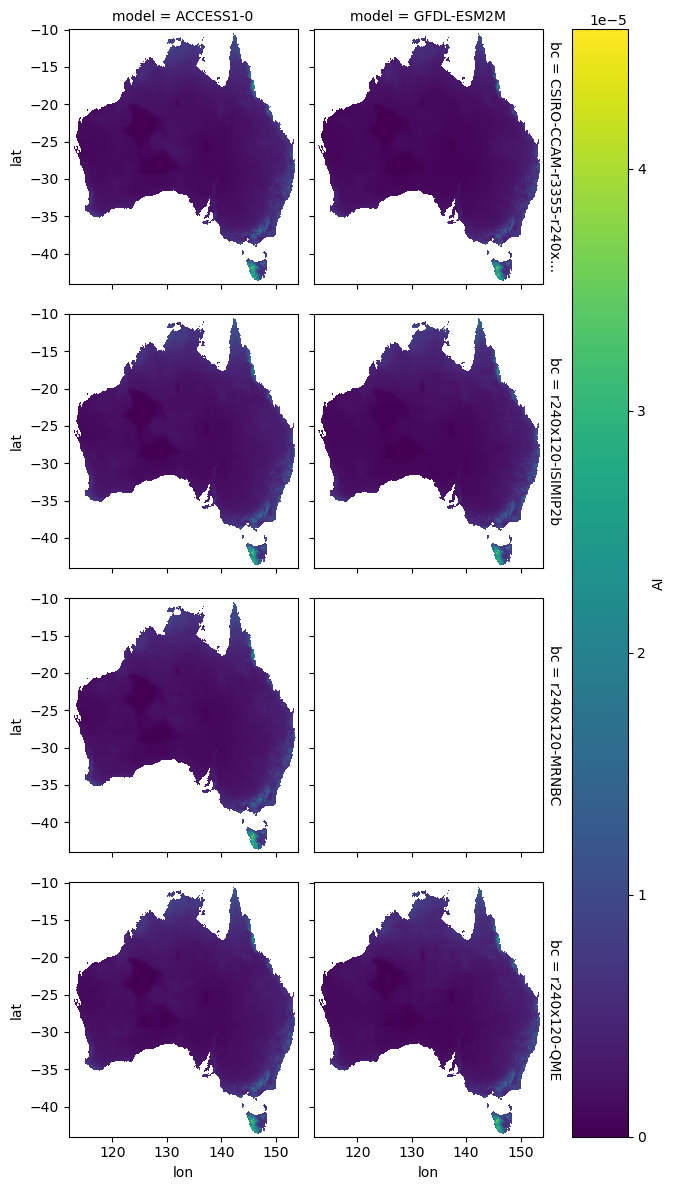

In [20]:
da_rcp45_gwl15 = da_all.sel(rcp='rcp45',gwl='1.5')
da_rcp45_gwl15.AI.plot(row='bc',col='model')

In [ ]:
# time = 'recent' #'GWL2-ssp370'
# source = 'AGCD'
# model = 'ACCESS-ESM1-5'        

#< Get files
for time in climatology:
    for source in source_char:
        print(source)
        if source == 'CMIP6':
                
            for model in source_char[source]:
                name = source+'-'+model

                # # bias correction
                # bias_pet = sorted(lib_david.get_file_paths("/g/data/fj8/BoM/AWRA/DATA/v7/simulation/",".nc",["e0"]))
                # bias_p = sorted(lib_david.get_file_paths("/g/data/zv2/agcd/v1-0-1/precip/total/r005/01month/",".nc",["agcd_v1-0-1_precip_total_r005_monthly"]))
    
                if time == 'GWL2-ssp126' or time == 'GWL2-ssp370':
                    if climatology[time][model]['start']: climstart = climatology[time][model]['start']
                    if climatology[time][model]['end']: climend = climatology[time][model]['end']
                    else:
                        print('{} does not reach GWL.'.format(model))
                        continue

                else:
                    climstart = climatology[time]['start']
                    climend = climatology[time]['end']
                    
        
                file_name = "{}AI_{}_{}_{}-{}.nc".format(out_dir,name,time,climstart,climend)
                print(file_name)
                if os.path.exists(file_name)==False:
                    print('Computing AI for {} for {} period ({}-{})'.format(name,time,climstart,climend))

                    filtered_files = {'pet':[file for file in source_char[source][model]['files']['pet_files'] if any(str(year) in file for year in range(climstart,climend+1))],
                                      'p':[file for file in source_char[source][model]['files']['p_files'] if any(str(year) in file for year in range(climstart,climend+1))]}
                    print(filtered_files)
                    #< Calculate AI
                    AI = lib_david.calc_AI(filtered_files,source,source_char,model=model)
                    print(AI)
                
                    #< Save output
                    saver = AI.to_netcdf(file_name, compute=False, encoding=enc)
                    future = client.persist(saver)
                    dask.distributed.progress(future)
                    future.compute()
                    
        elif time != 'recent' and source != 'CMIP6':
            print('{} time for {} does not exist'.format(time,source))
            pass
        
        else:
            climstart = climatology[time]['start']
            climend = climatology[time]['end']
            
            name = source
           
            file_name = "{}AI_{}_{}_{}-{}.nc".format(out_dir,name,time,climstart,climend)
            if os.path.exists(file_name)==False:
                print('Computing AI for {} for {} period ({}-{})'.format(name,time,climstart,climend))

                filtered_files = {'pet':[file for file in source_char[source]['files']['pet_files'] if any(str(year) in file for year in range(climstart, climend + 1)) and 'processed' not in file],
                                  'p':[file for file in source_char[source]['files']['p_files'] if any(str(year) in file for year in range(climstart,climend+1))]}
 
                #< Calculate AI
                AI = lib_david.calc_AI(filtered_files,source,source_char)
                # print(AI)
            
                #< Save output
                saver = AI.to_netcdf(file_name, compute=False, encoding=enc)
                future = client.persist(saver)
                dask.distributed.progress(future)
                future.compute()
                          

       
# p_files[model] = [file for file in ifile if any(str(year) in file for year in range(climatology['recent']['start'],climatology['recent']['end']+1))
#                                          or any(str(year) in file for year in range(climatology['current']['start'],climatology['current']['end']+1))
#                                          or any(str(year) in file for year in range(climatology['GWL2-ssp370'][model]['start'],climatology['GWL2-ssp370'][model]['end']+1))]


In [ ]:
filtered_paths = [file for file in source_char['AGCD']['files']['pet_files'] if any(str(year) in file for year in range(climstart,climend+1))]
filtered_paths2 = [path for path in filtered_paths if 'processed' not in path]
filtered_paths2